# References in the New York Times to Israel and Palestine

In [1]:
import requests
import re

from os.path import join
from os.path import basename
import urllib.parse
import math
import json
import time
import datetime
from datetime import timedelta

import nltk
from nltk import word_tokenize,sent_tokenize,pos_tag
from nltk.stem import WordNetLemmatizer
lemmatiser = WordNetLemmatizer()

import pandas as pd
import json

import os
from os.path import join
import datetime

from collections import Counter

import string


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

ana = SentimentIntensityAnalyzer()

from nltk.corpus import stopwords
stopword_list = stopwords.words('english')
stopword_list.extend(['s','mrs','mr','nt','h'])
for mark in string.punctuation + '“”’—‘':
    stopword_list.append(mark)
    
stopword_list = [word.lower() for word in stopword_list]

import seaborn as sns
import matplotlib.pyplot as plt

from nltk import sent_tokenize, word_tokenize



## Retrieve all articles in the NYT containing the word "Israel"

In [2]:
def get_article_data(json):
    data = dict()
    data['abstract'] = json['abstract']
    data['snippet'] = json['snippet']
    data['pub_date'] = json['pub_date']
    data['uri'] = json['uri']
    data['lead_paragraph'] = json['lead_paragraph']
    if 'section_name' in json:
        data['section_name'] = json['section_name']
    if 'subsection_name' in json:
        data['subsection_name'] = json['subsection_name']
    data['main_headline'] = json['headline']['main']
    data['print_headline'] = json['headline']['print_headline']
    return data

def sorted_by_value( dict , ascending = True ):
    if ascending: 
        return {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    else:
        return {k: v for k, v in reversed( sorted(dict.items(), key=lambda item: item[1]))}
    

The code below requests information about all the articles in the New York Times containing the word "Israel" in between 1 October 2023 and 31 January 2024. 

Separate queries are sent for each day of the year. The API does not returns the full text of the article, but only the title, the abstract, a lead paragraph and a snippet. These results are assumed to be sufficient to develop an impression of the main contents of these articles. 

In [3]:
# term = 'israel'

# articles = []

# start_day = datetime.date(2023,10,1)
# end_day = datetime.date(2024,2,1)


# while start_day < end_day:

#     query_start= start_day.strftime('%Y%m%d')
#     start_day = start_day+datetime.timedelta(days=1)
#     query_end= start_day.strftime('%Y%m%d')

#     nr_pages = 0 
#     url=f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={term}&api-key={api_key}&fq=source:%22The%20New%20York%20Times%22&begin_date={query_start}&end_date={query_end}'
#     print(url)

#     response = requests.get(url)
#     print(response.status_code)
#     time.sleep(12)

#     if response:
#         json_data = response.json()
#         for doc in json_data['response']['docs']:
#             articles.append(get_article_data(doc))
        

#         nr_results = json_data['response']['meta']['hits']
#         nr_pages = math.ceil( nr_results/10 )
#         print(f'{nr_results} results, {nr_pages} page',end='')
#         if nr_pages>1:
#             print('s',end='')
#         print('.')

#     if nr_pages > 1:
#         for page_nr in range(2,nr_pages+1):
#             next_url = f'{url}&page={page_nr}'
#             print(next_url)
#             response = requests.get(next_url)
#             time.sleep(12)
#             if response:
#                 json_data = response.json()
#                 for doc in json_data['response']['docs']:
#                     articles.append(get_article_data(doc))
            
#     for article in articles:
#         file_name = article['uri']
#         article['scope'] = term
#         file_name = f'{basename(file_name)}.json'
#         with open(join(term.title(),file_name),'w',encoding='utf-8') as out:
#             json_object = json.dumps(article, indent = 4)
#             out.write(json_object)          

## Number of articles

How many articles were published containing the search term? The counts are aggregated at the level of weeks. 

In [4]:
directory = 'Israel'
files = os.listdir(directory)
files = [file for file in files if re.search('json$',file)]

all_weeks = []

for file in files:
    json_file = open(join(directory,file),encoding='utf-8')
    json_data = json.load(json_file)
    year = pd.to_datetime(json_data['pub_date']).year
    week = pd.to_datetime(json_data['pub_date']).isocalendar()[1]
    all_weeks.append(f'{year}-{week}')
    
week_count = Counter(sorted(all_weeks))

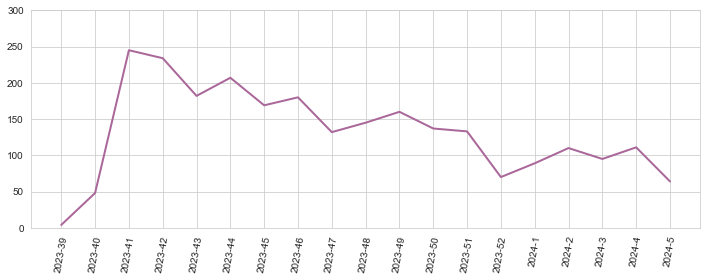

In [5]:
x_axis = list(week_count.keys())
y_axis = list(week_count.values())

sns.set_style("whitegrid")

fig = plt.figure( figsize = ( 12, 4))
ax = sns.lineplot(x=x_axis,y=y_axis,
                  color= '#AA6799',linestyle='solid',linewidth=2 )
ax.set(ylim=(0,300))

plt.xticks(rotation= 80)
plt.show()

## Topic Modelling

The articles that were found using this method are saved in a folder named 'TXT'. They are analysed, firstly, using Topic Modelling. In short, this is a technique which analyses the words that are used in a large collection of texts, and which aims to identify the word clusters belonging to a single 'semantic domain' or topic. Words which co-occur frequently in different documents can be taken to be 'about' the same subject. For more information, see section 2.3 on "Semantic Text Mining" in [Tool criticism in practice](https://digitalhumanities.org/dhq/vol/17/2/000687/000687.html)

In [6]:
directory = 'Israel'
sub_directory = 'TXT'
sub_dir_path = join(directory,sub_directory)
if not os.path.exists(sub_dir_path):
    os.makedirs(sub_dir_path)

In [7]:
files = os.listdir(directory)
files = [file for file in files if not(re.search('^[.]',file))]

for file in files:
    path = join(directory,file)
    if path != sub_dir_path:
        with open(path) as fh:
            article = json.load(fh)
            if 'scope' in article and article['scope'] == 'italy':
                full_text = article['main_headline'].strip()
                full_text += '. ' + article['abstract']
                if article['abstract'].strip() != article['snippet'].strip():
                    full_text += '. ' + article['snippet']  
                full_text += '. ' + article['lead_paragraph']
                full_text = re.sub('[.]{2,}','.',full_text)

                out_file = re.sub('\.json','.txt',file)

                with open(join(sub_dir_path,out_file),'w',encoding='utf-8') as out:
                    out.write(full_text)

The code below tries to identify 10 topics. 

In [8]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

file_names = []

for item in os.listdir(sub_dir_path):
    if re.search( 'txt$' , item ):
        file_names.append(join(sub_dir_path,item))

nmf_vectorizer = TfidfVectorizer(input='filename', analyzer='word', min_df=1, strip_accents = None, stop_words='english', preprocessor=None, encoding = 'utf-8')

features = nmf_vectorizer.fit_transform(file_names)
words = nmf_vectorizer.get_feature_names_out()


nr_topics = 10

topic_model = NMF(n_components=nr_topics, random_state=42, init='nndsvd', max_iter=2000) 
topic_model.fit(features)

NMF(init='nndsvd', max_iter=2000, n_components=10, random_state=42)

In [9]:
nr_words = 30

for topic_id, topic in enumerate(topic_model.components_):
    print( f"\nTopic #{topic_id}:\n" )
    word_list = ''
    for i in topic.argsort()[:-nr_words - 1:-1]:
        word_list += words[i] + '; '
    word_list = re.sub(';\s+$', '', word_list)
    print(word_list)


Topic #0:

gaza; israeli; strip; military; invasion; israel; ground; said; border; southern; egypt; briefing; city; northern; civilians; palestinians; territory; airstrikes; humanitarian; aid; troops; people; officials; south; strikes; forces; thousands; water; enclave; gazans

Topic #1:

news; times; storytelling; journalism; audio; ios; download; serendipity; depth; provides; app; subscribers; available; newsletter; haven; weekly; sign; home; new; york; plus; hear; minutes; deal; audiophiles; share; gaza; best; listen; biden

Topic #2:

biden; president; ukraine; israel; aid; war; middle; trump; administration; east; american; support; states; united; china; world; trip; climate; xi; russia; donald; state; summit; wednesday; visit; conflict; harris; voters; leaders; iran

Topic #3:

hospital; al; shifa; gaza; explosion; blast; complex; said; israeli; hundreds; city; killed; largest; people; patients; hamas; palestinian; officials; military; arab; medical; health; says; ahli; babies;

In [10]:
israel_adj = Counter()

for nr in range(0,nr_topics):
    
    print(f'\n\nTopic {nr}\n')

    full_text = ''
    entities = []

    doc_topic = topic_model.transform(features)

    for n in range(doc_topic.shape[0]):
        ## retrieve all the texts about the topic
        highest_score = doc_topic[n].argmax()
        if highest_score == nr:
            file = file_names[n]
            with open(file) as fh:
                full_text += fh.readlines()[0].strip() + ' '
                full_text = full_text.lower()
   

    # Find most frequent words
    maxNr = 20
    print(f'\n{maxNr} most frequent words:')
    words = word_tokenize(full_text)
    words = [word for word in words if word not in stopword_list]
    freq = Counter(words)
    for word,i in freq.most_common(maxNr):
        print(f'{word} ({i})')
    
    # Sentiment Analysis
    sent_scores = dict()
    for word,count in freq.most_common():
        scores = ana.polarity_scores(word)
        sent_scores[word] = scores['compound']
        
    
    print(f'\n{maxNr} most positive words:')
    count = 0
    for word in sorted_by_value(sent_scores,ascending=False):
        if sent_scores[word]<0:
            print(word,'\t',sent_scores[word])
            count += 1
            if count == maxNr:
                break
    print(f'\n{maxNr} most negative words:')
    count = 0
    for word in sorted_by_value(sent_scores,ascending=True):
        if sent_scores[word]<0:
            print(word,'\t',sent_scores[word])
            count += 1
            if count == maxNr:
                break

    # Part of Speech Tagging
    adj_adv = []     
    pos = pos_tag(words)

    for p in pos:
        if re.search( '^(JJ)',p[1]) or re.search( '^(RB)',p[1]):
            adj_adv.append(p[0])

    freq_adj_adv = Counter(adj_adv)
    israel_adj.update(adj_adv)
    
    print(f'\n{maxNr} most frequent adjectives and adverbs:')
    for word,i in freq_adj_adv.most_common(maxNr):
        print(f'{word} ({i})')   




Topic 0


20 most frequent words:
gaza (555)
israel (278)
israeli (253)
said (123)
military (119)
hamas (100)
strip (99)
war (95)
ground (74)
invasion (73)
palestinians (70)
officials (69)
palestinian (68)
people (68)
border (67)
city (63)
u.s. (62)
egypt (60)
aid (60)
southern (57)

20 most positive words:
preventing 	 -0.0258
thwarted 	 -0.0258
trickling 	 -0.0516
backs 	 -0.0516
fighters 	 -0.0516
leave 	 -0.0516
imposed 	 -0.0772
imposing 	 -0.1027
costly 	 -0.1027
cautious 	 -0.1027
warn 	 -0.1027
warns 	 -0.1027
questioning 	 -0.1027
hard 	 -0.1027
lowered 	 -0.128
tough 	 -0.128
rebellion 	 -0.128
strike 	 -0.128
looming 	 -0.128
falling 	 -0.1531

20 most negative words:
kill 	 -0.6908
terrorist 	 -0.6908
terrorism 	 -0.6808
hell 	 -0.6808
killed 	 -0.6705
killing 	 -0.6597
catastrophe 	 -0.6597
devil 	 -0.6597
horrific 	 -0.6597
cancer 	 -0.6597
dead 	 -0.6486
devastating 	 -0.6486
hatred 	 -0.6369
murderous 	 -0.6369
crisis 	 -0.6249
violence 	 -0.6249
disaster 	 -0.6249
te


20 most frequent words:
israel (579)
hamas (487)
gaza (260)
war (251)
israeli (221)
attack (171)
oct. (160)
hostages (151)
7 (125)
said (118)
palestinian (102)
attacks (101)
people (88)
two (86)
israel-hamas (84)
killed (78)
officials (76)
cease-fire (74)
released (72)
hostage (66)

20 most positive words:
longing 	 -0.0258
overlooked 	 -0.0258
indifference 	 -0.0516
leave 	 -0.0516
fighters 	 -0.0516
exposed 	 -0.0772
collide 	 -0.0772
solemn 	 -0.0772
shaken 	 -0.0772
accidental 	 -0.0772
rainy 	 -0.0772
lobbying 	 -0.0772
sorry 	 -0.0772
serious 	 -0.0772
stunned 	 -0.1027
reluctantly 	 -0.1027
questioned 	 -0.1027
warns 	 -0.1027
questioning 	 -0.1027
warn 	 -0.1027

20 most negative words:
raping 	 -0.7003
terrorist 	 -0.6908
murder 	 -0.6908
rape 	 -0.6908
murder. 	 -0.6908
kill 	 -0.6908
terrorism 	 -0.6808
hell 	 -0.6808
terrorism. 	 -0.6808
raped 	 -0.6808
killed 	 -0.6705
killings 	 -0.6705
suicide 	 -0.6705
killing 	 -0.6597
murdered 	 -0.6597
tragedy 	 -0.6597
catastrophe 

### Cooccurrences

Which words are used in the vicinity in the following words:

* netanyahu
* gaza 
* rafah
* ceasefire
* terrorist

In [11]:

terms = ['netanyahu','gaza','rafah','ceasefire','terrorist']

for term in terms:
    
    print(f'\n{term}\n')

    stopword_list.append(term.lower())

    freq = Counter()
    for file in files:
        path = join(directory,file)
        if path != sub_dir_path:
            with open(path) as fh:
                article = json.load(fh)
                if 'scope' in article and article['scope'] == 'italy':
                    full_text = article['main_headline'].strip()
                    full_text += '. ' + article['abstract']
                    if article['abstract'].strip() != article['snippet'].strip():
                        full_text += '. ' + article['snippet']  
                    full_text += '. ' + article['lead_paragraph']
                    full_text = re.sub('[.]{2,}','.',full_text)
                    sentences = sent_tokenize(full_text)
                    for sentence in sentences:
                        if re.search(r'\b{}\b'.format(term),sentence,re.IGNORECASE):
                            words = word_tokenize(sentence.lower())
                            words = [word for word in words if not word in stopword_list]
                            freq.update(words)

    for word,count in freq.most_common(30):
        print(f'{word}\t{count}')


netanyahu

minister	71
benjamin	68
prime	66
israel	54
gaza	32
hamas	30
war	20
israeli	19
government	15
president	13
biden	12
said	12
would	11
military	10
leaders	9
opposition	8
attack	8
palestinian	8
security	8
former	7
cabinet	7
strip	7
country	7
people	7
formed	6
wednesday	6
invasion	6
sunday	6
hostages	6
oct.	6

gaza

israel	530
israeli	285
hamas	278
war	197
said	171
strip	166
hospital	145
military	131
people	105
palestinian	96
city	90
officials	85
invasion	81
ground	80
aid	73
biden	73
hostages	73
killed	71
u.s.	67
civilians	66
palestinians	64
oct.	61
hundreds	59
border	59
two	58
humanitarian	58
president	58
southern	58
7	55
egypt	54

rafah

egypt	12
crossing	11
border	8
foreign	3
nationals	3
southern	3
leave	3
northern	3
waited	3
monday	3
across	3
u.s.	3
would	3
many	3
side	3
said	2
get	2
wednesday	2
wounded	2
territory	2
israel	2
people	2
day	2
first	2
aid	2
water	2
scores	2
including	2
citizens	2
hoping	2

ceasefire


terrorist

israel	35
hamas	35
attacks	21
oct.	17
7	16
attack	

## Sentiment Analysis

What is the ration between positivity and negativity? Do the articles contain more 'potitive' sentences than 'negative' sentences?

In [12]:
data = []
nr_sentences = 0
count_positive = 0
count_negative = 0
israel_sentences = dict()

files = os.listdir(sub_dir_path)
files = [join(sub_dir_path,file) for file in files if re.search(r'txt$',file)]

for file in files: 

    text = open(file,encoding='utf-8')
    full_text = text.read()
    sentences = sent_tokenize(full_text)
    for sentence in sentences:
        scores = ana.polarity_scores(sentence)
        nr_sentences += 1
        israel_sentences[sentence] = scores['compound']
        if scores['compound'] > 0.6:
            count_positive+=1
        elif scores['compound'] < -0.6:
            count_negative+=1

        

count_neutral = nr_sentences - count_positive-count_negative

data.append( ['Female',count_neutral/nr_sentences,count_positive/nr_sentences,count_negative/nr_sentences])
df = pd.DataFrame(data,columns=['country','neutral','positive','negative'])

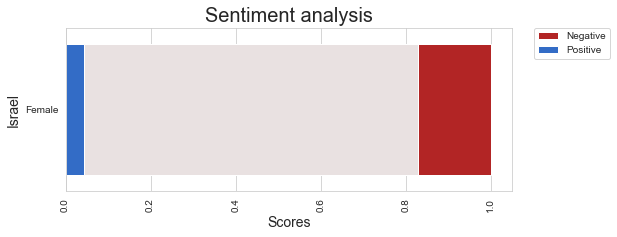

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


y_axis = 'country'

fig = plt.figure( figsize=( 8 , 3 ) )

df['combined'] = df['positive'] + df['neutral'] + df['negative']
graph = sns.barplot( data=df , x='combined', y=y_axis , label = 'Negative', color = '#c90e0e' )
df['combined'] = df['combined'] - df['negative']
graph = sns.barplot( data=df , x='combined', y=y_axis , color = '#ebdfdf')
df['combined'] = df['combined'] - df['neutral']
graph = sns.barplot( data=df , x='combined', y=y_axis , label = 'Positive' ,color = '#1b66de')

graph.set_title('Sentiment analysis' , size = 20) 
graph.set_xlabel('Scores' , size = 14) 
graph.set_ylabel('Israel' , size = 14 )

plt.xticks(rotation= 90)

# The next line places the legend outside out the plot
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);

plt.show()

What are the 10 most negative sentences?

In [14]:
iterator = iter(sorted_by_value(israel_sentences).items())
for i in range(10):
    item = next(iterator)
    print(item[0], item[1])

Against a backdrop of mounting international outrage over civilian casualties as Israel wages war on Hamas, President Emmanuel Macron of France on Friday called on Israel to stop the killing in Gaza. . Against a backdrop of mounting international outrage over civilian casualties as Israel wages war on Hamas, President Emmanuel Macron of France on Friday called on Israel to stop the killing in Gaza. -0.981
The reason the Hamas-Israel war can be hard for outsiders to understand is that three wars are going on at the same time: a war between Israeli Jews and the Palestinians exacerbated by a terrorist group, a war within Israeli and Palestinian societies over the future and a war between Iran and its proxies and America and its allies. -0.9783
Hundreds of people were feared dead after an explosion at a hospital in the Gaza Strip on Oct. 17, a little over a week after the Palestinian group Hamas staged a terrorist attack on Israel that killed 1,400 people and led Israel to declare war and 

What are the 10 most positive sentences?

In [15]:
iterator = iter(sorted_by_value(israel_sentences,ascending=False).items())
for i in range(10):
    item = next(iterator)
    print(item[0], item[1])

The novel, which was a finalist for the National Book Award and was longlisted for the International Booker Prize, was to be honored for having won the 2023 LiBeraturpreis, a German literary prize awarded annually to a woman from the developing world. 0.9705
On a rainy night in June, President Biden toasted Prime Minister Narendra Modi of India during a state dinner at the White House, celebrating “two great friends, and two great powers” — a gesture of flattery for a leader he has enlisted to help the United States check China’s ambition and counter Russia’s aggression. 0.9607
He put his influence and reputation on the line to make the case that it was in the United States’ interest to help a beleaguered democracy trying to beat a Russian invasion led by Vladimir V. Putin, and expressed confidence that his party would join him. 0.9403
Trump’s presidency was a period not just of steady growth and low unemployment, but also of growth that was more widely shared than in much of the recen

## Retrieve all articles in the NYT containing the word "Palestine"

The code below requests information about all the articles in the New York Times containing the word "Palestine" in between 1 October 2023 and 31 January 2024. 

Separate queries are sent for each day of the year. The API does not returns the full text of the article, but only the title, the abstract, a lead paragraph and a snippet. These results are assumed to be sufficient to develop an impression of the main contents of these articles. 

In [16]:
# term = 'palestine'

# articles = []

# start_day = datetime.date(2023,10,1)
# end_day = datetime.date(2024,2,1)


# while start_day < end_day:

#     query_start= start_day.strftime('%Y%m%d')
#     start_day = start_day+datetime.timedelta(days=1)
#     query_end= start_day.strftime('%Y%m%d')

#     nr_pages = 0 
#     url=f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={term}&api-key={api_key}&fq=source:%22The%20New%20York%20Times%22&begin_date={query_start}&end_date={query_end}'
#     print(url)

#     response = requests.get(url)
#     print(response.status_code)
#     time.sleep(12)

#     if response:
#         json_data = response.json()
#         for doc in json_data['response']['docs']:
#             articles.append(get_article_data(doc))
        

#         nr_results = json_data['response']['meta']['hits']
#         nr_pages = math.ceil( nr_results/10 )
#         print(f'{nr_results} results, {nr_pages} page',end='')
#         if nr_pages>1:
#             print('s',end='')
#         print('.')

#     if nr_pages > 1:
#         for page_nr in range(2,nr_pages+1):
#             next_url = f'{url}&page={page_nr}'
#             print(next_url)
#             response = requests.get(next_url)
#             time.sleep(12)
#             if response:
#                 json_data = response.json()
#                 for doc in json_data['response']['docs']:
#                     articles.append(get_article_data(doc))
            
#     for article in articles:
#         file_name = article['uri']
#         article['scope'] = term
#         file_name = f'{basename(file_name)}.json'
#         with open(join(term.title(),file_name),'w',encoding='utf-8') as out:
#             json_object = json.dumps(article, indent = 4)
#             out.write(json_object)          

## Number of articles

How many articles were published containing the search term? The counts are aggregated at the level of weeks. 

In [17]:
directory = 'Palestine'
files = os.listdir(directory)
files = [file for file in files if re.search('json$',file)]

all_weeks = []

for file in files:
    json_file = open(join(directory,file),encoding='utf-8')
    json_data = json.load(json_file)
    year = pd.to_datetime(json_data['pub_date']).year
    week = pd.to_datetime(json_data['pub_date']).isocalendar()[1]
    all_weeks.append(f'{year}-{week}')
    
week_count = Counter(sorted(all_weeks))

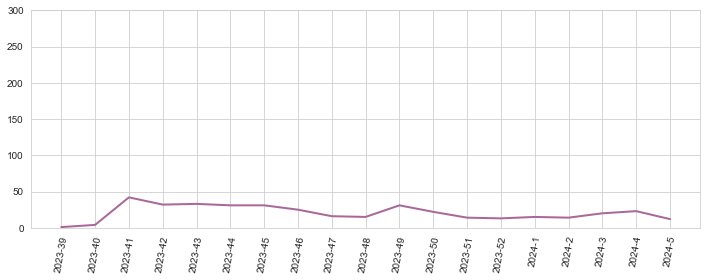

In [18]:
x_axis = list(week_count.keys())
y_axis = list(week_count.values())

sns.set_style("whitegrid")

fig = plt.figure( figsize = ( 12, 4))
ax = sns.lineplot(x=x_axis,y=y_axis,
                  color= '#AA6799',linestyle='solid',linewidth=2 )
ax.set(ylim=(0,300))

plt.xticks(rotation= 80)
plt.show()

## Topic Modelling

The articles that were found using this method are saved in a folder named 'TXT'. They are analysed, firstly, using Topic Modelling. In short, this is a technique which analyses the words that are used in a large collection of texts, and which aims to identify the word clusters belonging to a single 'semantic domain' or topic. Words which co-occur frequently in different documents can be taken to be 'about' the same subject. For more information, see section 2.3 on "Semantic Text Mining" in [Tool criticism in practice](https://digitalhumanities.org/dhq/vol/17/2/000687/000687.html)

In [19]:
directory = 'Palestine'
sub_directory = 'TXT'
sub_dir_path = join(directory,sub_directory)
if not os.path.exists(sub_dir_path):
    os.makedirs(sub_dir_path)
print(sub_dir_path)

Palestine/TXT


In [20]:
files = os.listdir(directory)
files = [file for file in files if not(re.search('^[.]',file))]

for file in files:
    path = join(directory,file)
    if path != sub_dir_path:
        with open(path) as fh:
            article = json.load(fh)
            if 'scope' in article and article['scope'] == 'palestine':
                full_text = article['main_headline'].strip()
                full_text += '. ' + article['abstract']
                if article['abstract'].strip() != article['snippet'].strip():
                    full_text += '. ' + article['snippet']  
                full_text += '. ' + article['lead_paragraph']
                full_text = re.sub('[.]{2,}','.',full_text)

                out_file = re.sub('\.json','.txt',file)

                with open(join(sub_dir_path,out_file),'w',encoding='utf-8') as out:
                    out.write(full_text)

The code below tries to identify 10 topics. 

In [21]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

file_names = []

for item in os.listdir(sub_dir_path):
    if re.search( 'txt$' , item ):
        file_names.append(join(sub_dir_path,item))

nmf_vectorizer = TfidfVectorizer(input='filename', analyzer='word', min_df=1, strip_accents = None, stop_words='english', preprocessor=None, encoding = 'utf-8')

features = nmf_vectorizer.fit_transform(file_names)
words = nmf_vectorizer.get_feature_names_out()


nr_topics = 10

topic_model = NMF(n_components=nr_topics, random_state=42, init='nndsvd', max_iter=2000) 
topic_model.fit(features)

NMF(init='nndsvd', max_iter=2000, n_components=10, random_state=42)

In [22]:
nr_words = 30

for topic_id, topic in enumerate(topic_model.components_):
    print( f"\nTopic #{topic_id}:\n" )
    word_list = ''
    for i in topic.argsort()[:-nr_words - 1:-1]:
        word_list += words[i] + '; '
    word_list = re.sub(';\s+$', '', word_list)
    print(word_list)


Topic #0:

gaza; israeli; killed; israel; people; airstrikes; strip; military; said; southern; officials; hamas; hospitals; younis; khan; homes; palestinians; hezbollah; family; gazans; thousands; attack; say; hundreds; border; lebanon; ground; bombardment; near; territory

Topic #1:

ezra; klein; episode; conversation; matters; invites; transcript; listen; podcasts; interviews; today; 2023; friday; like; tuesday; dec; nov; gloria; amjad; nimrod; novik; zack; beauchamp; baconi; tareq; mark; sharon; brous; iraqi; tom

Topic #2:

university; campus; harvard; students; columbia; campuses; college; student; pro; speech; antisemitism; hamas; palestinian; universities; presidents; president; weeks; israel; gay; protest; free; tensions; war; claudine; say; protests; jewish; investigation; rights; groups

Topic #3:

new; city; york; pro; protests; cease; palestinian; brooklyn; demonstrators; streets; thousands; manhattan; israel; war; jewish; protesters; hundreds; hamas; people; police; londo

In [23]:
palestine_adj = Counter()

for nr in range(0,nr_topics):
    
    print(f'\n\nTopic {nr}\n')

    full_text = ''
    entities = []

    doc_topic = topic_model.transform(features)

    for n in range(doc_topic.shape[0]):
        ## retrieve all the texts about the topic
        highest_score = doc_topic[n].argmax()
        if highest_score == nr:
            file = file_names[n]
            with open(file) as fh:
                full_text += fh.readlines()[0].strip() + ' '
                full_text = full_text.lower()
   

    # Find most frequent words
    maxNr = 20
    print(f'\n{maxNr} most frequent words:')
    words = word_tokenize(full_text)
    words = [word for word in words if word not in stopword_list]
    freq = Counter(words)
    for word,i in freq.most_common(maxNr):
        print(f'{word} ({i})')
    
    # Sentiment Analysis
    sent_scores = dict()
    for word,count in freq.most_common():
        scores = ana.polarity_scores(word)
        sent_scores[word] = scores['compound']
        
    
    print(f'\n{maxNr} most positive words:')
    count = 0
    for word in sorted_by_value(sent_scores,ascending=False):
        if sent_scores[word]<0:
            print(word,'\t',sent_scores[word])
            count += 1
            if count == maxNr:
                break
    print(f'\n{maxNr} most negative words:')
    count = 0
    for word in sorted_by_value(sent_scores,ascending=True):
        if sent_scores[word]<0:
            print(word,'\t',sent_scores[word])
            count += 1
            if count == maxNr:
                break

    # Part of Speech Tagging
    adj_adv = []     
    pos = pos_tag(words)

    for p in pos:
        if re.search( '^(JJ)',p[1]) or re.search( '^(RB)',p[1]):
            adj_adv.append(p[0])

    freq_adj_adv = Counter(adj_adv)
    palestine_adj.update(adj_adv)
    
    print(f'\n{maxNr} most frequent adjectives and adverbs:')
    for word,i in freq_adj_adv.most_common(maxNr):
        print(f'{word} ({i})')   




Topic 0


20 most frequent words:
israel (59)
israeli (47)
hamas (27)
war (26)
killed (22)
said (21)
people (19)
military (17)
officials (17)
strip (15)
airstrikes (14)
palestinians (14)
southern (14)
family (14)
attack (14)
say (12)
palestinian (12)
hospitals (11)
gazans (11)
city (11)

20 most positive words:
fighters 	 -0.0516
leave 	 -0.0516
warns 	 -0.1027
hard 	 -0.1027
tough 	 -0.128
strike 	 -0.128
looms 	 -0.1531
confronting 	 -0.1531
shortages 	 -0.1531
anxiety 	 -0.1779
hide 	 -0.1779
seriously 	 -0.1779
empty 	 -0.2023
vulnerable 	 -0.2263
alone 	 -0.25
unclear 	 -0.25
protest 	 -0.25
struck 	 -0.25
charges 	 -0.2732
cut 	 -0.2732

20 most negative words:
kill 	 -0.6908
terrorism 	 -0.6808
killed 	 -0.6705
killing 	 -0.6597
cancer 	 -0.6597
dead 	 -0.6486
devastating 	 -0.6486
fatally 	 -0.6369
violence 	 -0.6249
crisis 	 -0.6249
brutal 	 -0.6249
disaster 	 -0.6249
devastated 	 -0.6124
war 	 -0.5994
death 	 -0.5994
die 	 -0.5994
violent 	 -0.5994
assault 	 -0.5859
poisoni


20 most frequent adjectives and adverbs:
east (25)
middle (17)
palestinian (7)
regional (7)
israel (7)
federal (6)
biden (5)
united (5)
al-arouri (5)
palestine (5)
u.s. (4)
iran (4)
new (4)
even (4)
still (4)
also (4)
top (4)
white (4)
israel-hamas (4)
saleh (4)


Topic 8


20 most frequent words:
israel (22)
court (19)
genocide (16)
south (11)
world (10)
case (9)
international (9)
africa (8)
palestinian (7)
justice (7)
book (7)
brought (6)
united (6)
war (6)
much (5)
week (5)
nations (5)
committing (5)
become (5)
see (5)

20 most positive words:
dragged 	 -0.0516
fighters 	 -0.0516
domination 	 -0.0516
hard 	 -0.1027
demand 	 -0.128
seriously 	 -0.1779
confront 	 -0.1779
accusing 	 -0.1779
risky 	 -0.2023
accusation 	 -0.25
loomed 	 -0.2732
charges 	 -0.2732
weapon 	 -0.296
pressure 	 -0.296
stop 	 -0.296
accused 	 -0.296
fought 	 -0.3182
perversion 	 -0.3182
mourned 	 -0.3182
lost 	 -0.3182

20 most negative words:
murderous 	 -0.6369
brutal 	 -0.6249
terrorists 	 -0.6249
violence 	

### Cooccurrences

Which words are used in the vicinity in the following words:

* netanyahu
* gaza 
* rafah
* ceasefire
* terrorist

In [24]:

terms = ['netanyahu','gaza','rafah','ceasefire','terrorist']

for term in terms:
    
    print(f'\n{term}\n')

    stopword_list.append(term.lower())

    freq = Counter()
    for file in files:
        path = join(directory,file)
        if path != sub_dir_path:
            with open(path) as fh:
                article = json.load(fh)
                if 'scope' in article and article['scope'] == 'palestine':
                    full_text = article['main_headline'].strip()
                    full_text += '. ' + article['abstract']
                    if article['abstract'].strip() != article['snippet'].strip():
                        full_text += '. ' + article['snippet']  
                    full_text += '. ' + article['lead_paragraph']
                    full_text = re.sub('[.]{2,}','.',full_text)
                    sentences = sent_tokenize(full_text)
                    for sentence in sentences:
                        if re.search(r'\b{}\b'.format(term),sentence,re.IGNORECASE):
                            words = word_tokenize(sentence.lower())
                            words = [word for word in words if not word in stopword_list]
                            freq.update(words)

    for word,count in freq.most_common(30):
        print(f'{word}\t{count}')


netanyahu

benjamin	13
israel	11
prime	9
minister	9
biden	7
israeli	6
hamas	5
united	5
palestinian	5
war	4
trump	4
could	4
president	3
support	3
leader	3
american	3
jews	3
pressure	3
calls	3
states	3
palestinians	2
attack	2
strip	2
death	2
three	2
days	2
day	2
air	2
u.s.	2
turning	2

gaza

israel	127
war	66
israeli	61
hamas	47
palestinian	29
palestinians	26
strip	25
said	25
people	21
hospital	20
killed	19
officials	19
city	18
state	17
military	16
attack	16
southern	15
border	15
one	14
south	14
years	14
oct.	13
day	13
attacks	13
biden	13
many	12
cease-fire	12
united	12
since	12
invasion	12

rafah

egypt	4
monday	3
border	3
across	2
scores	2
foreign	2
nationals	2
including	2
many	2
u.s.	2
citizens	2
waited	2
side	2
crossing	2
hoping	2
deal	2
would	2
allow	2
escape	2
premature	1
babies	1
intensive	1
care	1
al-shifa	1
hospital	1
northern	1
arrived	1
transported	1
according	1
state	1

ceasefire

ann	1
arbor	1
school	1
board	1
set	1
vote	1
israel-gaza	1
resolution	1

terrorist

israel	9
ham

## Sentiment Analysis

What is the ratio between positivity and negativity? Do the articles contain more 'potitive' sentences than 'negative' sentences?

In [25]:
data = []
nr_sentences = 0
count_positive = 0
count_negative = 0
palestine_sentences = dict()

path = join('Palestine','TXT')
files = os.listdir(path)
files = [join(path,file) for file in files if re.search(r'txt$',file)]

for file in files: 

    text = open(file,encoding='utf-8')
    full_text = text.read()
    sentences = sent_tokenize(full_text)
    for sentence in sentences:
        scores = ana.polarity_scores(sentence)
        nr_sentences += 1
        palestine_sentences[sentence] = scores['compound']
        if scores['compound'] > 0.6:
            count_positive+=1
        elif scores['compound'] < -0.6:
            count_negative+=1

        

count_neutral = nr_sentences - count_positive-count_negative

data.append( ['Female',count_neutral/nr_sentences,count_positive/nr_sentences,count_negative/nr_sentences])
df = pd.DataFrame(data,columns=['country','neutral','positive','negative'])

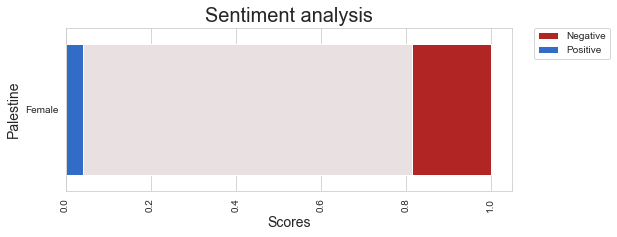

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


y_axis = 'country'

fig = plt.figure( figsize=( 8 , 3 ) )

df['combined'] = df['positive'] + df['neutral'] + df['negative']
graph = sns.barplot( data=df , x='combined', y=y_axis , label = 'Negative', color = '#c90e0e' )
df['combined'] = df['combined'] - df['negative']
graph = sns.barplot( data=df , x='combined', y=y_axis , color = '#ebdfdf')
df['combined'] = df['combined'] - df['neutral']
graph = sns.barplot( data=df , x='combined', y=y_axis , label = 'Positive' ,color = '#1b66de')

graph.set_title('Sentiment analysis' , size = 20) 
graph.set_xlabel('Scores' , size = 14) 
graph.set_ylabel('Palestine' , size = 14 )

plt.xticks(rotation= 90)

# The next line places the legend outside out the plot
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);

plt.show()

What are the 10 most negative sentences?

In [27]:
iterator = iter(sorted_by_value(palestine_sentences).items())
for i in range(10):
    item = next(iterator)
    print(item[0], item[1])

The reason the Hamas-Israel war can be hard for outsiders to understand is that three wars are going on at the same time: a war between Israeli Jews and the Palestinians exacerbated by a terrorist group, a war within Israeli and Palestinian societies over the future and a war between Iran and its proxies and America and its allies. -0.9783
A hostile environment that began with statements from pro-Palestinian student organizations justifying terrorism has now rapidly spiraled into death threats and physical attacks, leaving Jewish students alarmed and vulnerable. -0.9643
A clash between Iranian-backed Houthi fighters who were attacking a commercial freighter and U.S. Navy helicopters responding to the ship’s distress call ended on Sunday morning with the killing of all the crew members on three Houthi boats, the Pentagon said, a sharp escalation of violence at a moment when the White House is considering direct strikes on Iran’s proxies in the Middle East. -0.9559
After the deadliest as

What are the 10 most positive sentences?

In [28]:
iterator = iter(sorted_by_value(palestine_sentences,ascending=False).items())
for i in range(10):
    item = next(iterator)
    print(item[0], item[1])

The novel, which was a finalist for the National Book Award and was longlisted for the International Booker Prize, was to be honored for having won the 2023 LiBeraturpreis, a German literary prize awarded annually to a woman from the developing world. 0.9705
By the end of last week, England’s Football Association doubtless felt that it had done the best it could, that after hours and hours of talks, it had settled on what might best be described as the least worst option. 0.9273
Because this friend is lavishly generous and wasn’t sure of our child’s reading level, he showed up with a gift bag of titles about Palestinian children and their experiences, ranging from picture books to a four-volume series of middle-grade novels. 0.8934
A cherished tradition at Public School 261 in Boerum Hill, the heart of gentrified Brooklyn, is the annual march to Borough Hall in honor of Martin Luther King’s Birthday. 0.8934
The term is widely regarded as a rallying cry for the eradication of Israel, bu

## Part of Speech Tagging

Which adjective and adverbs in the articles on Israel are NEVER used in the articles on Palestine?

In [29]:
count = 0
for adj in israel_adj.keys():
    if adj not in palestine_adj.keys():
        count+=1
        print(adj)
        if count==30:
            break

gaza
acutely
perilous
urban
encircled
cut
peril
drag
volatile
newer
advanced
darkness
utterly
fringe
orient
wreckage
limited
objectionable
flee
squalid
cellular
underway
expanded
trickle.
trickle
fiercest
booby-trapped
armor-piercing
rather
condemn


In [30]:
count = 0
for adj in palestine_adj.keys():
    if adj not in israel_adj.keys():
        count+=1
        print(adj)
        if count==30:
            break

invading
presumably
noted
dignified
sabawi
wrapped
10-year-old
handmade
analysis
targeted
zaiter
comparative
possess
feasible
subterranean
near-total
ran
26-year-old
2-year-old
prenatal
nickname
10-week-old
urbi
orbi
appalling
klein
podcast
wide-ranging
reverse-chronological
87-year-old


In [31]:
if count==0:
    print('None of the words from the articles in palestine are unique.')